In [66]:
# Plotting and EDA libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import torch

from tqdm.auto import tqdm

# BERT utils
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Dataset
from datasets import load_dataset

In [2]:
plt.rcParams['figure.figsize'] = [13, 6]

In [3]:
# Set seeds for all libraries

GLOBAL_SEED = 1000

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)

In [4]:
IMG_DIR = "images"

RED = '#bd6464'
BLUE = '#6883b3'
GREEN = '#99bd75'
ORANGE = '#b08953'
ORANGE_SAT = '#ff9900'

BAR_COLORS = [RED, BLUE]

In [5]:
if not os.path.exists(IMG_DIR): os.mkdir(IMG_DIR)

## Data Loading and Preprocessing

In [6]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
sample_map = [
    (0, "Negative"),
    (1, "Positive")
]

In [9]:
# Show a sample each of positive and negative reviews

def print_samples(test_train_split):
    for i, label in sample_map:
        for index, sample in enumerate(dataset[test_train_split]):
            if sample['label'] == i:
                print(f"{label} Sample Text (Label {sample['label']}): {sample['text'][:50]}...{sample['text'][-50:]}")
                break

In [10]:
print_samples('train')

Negative Sample Text (Label 0): I rented I AM CURIOUS-YELLOW from my video store b...But really, this film doesn't have much of a plot.
Positive Sample Text (Label 1): Zentropa has much in common with The Third Man, an... sun shine. Grim, but intriguing, and frightening.


In [11]:
print_samples('test')

Negative Sample Text (Label 0): I love sci-fi and am willing to put up with a lot....ck as another actor. Jeeez! Dallas all over again.
Positive Sample Text (Label 1): Previous reviewer Claudio Carvalho gave a much bet...n be in that mood all the time, so, overall, 8.75.


In [12]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])

In [13]:
train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [14]:
test.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [15]:
def plot_distribution(train_test_split):

    label_counts = train_test_split['label'].value_counts()

    plt.bar(x = label_counts.index, height = label_counts.values, color = BAR_COLORS)

    plt.title('Labels Distribution in Training Data')
    plt.xlabel('Labels')
    plt.ylabel('Count')

    plt.xticks(ticks = [0, 1], labels = ['Negative', 'Positive'])

    plt.show()

    return label_counts

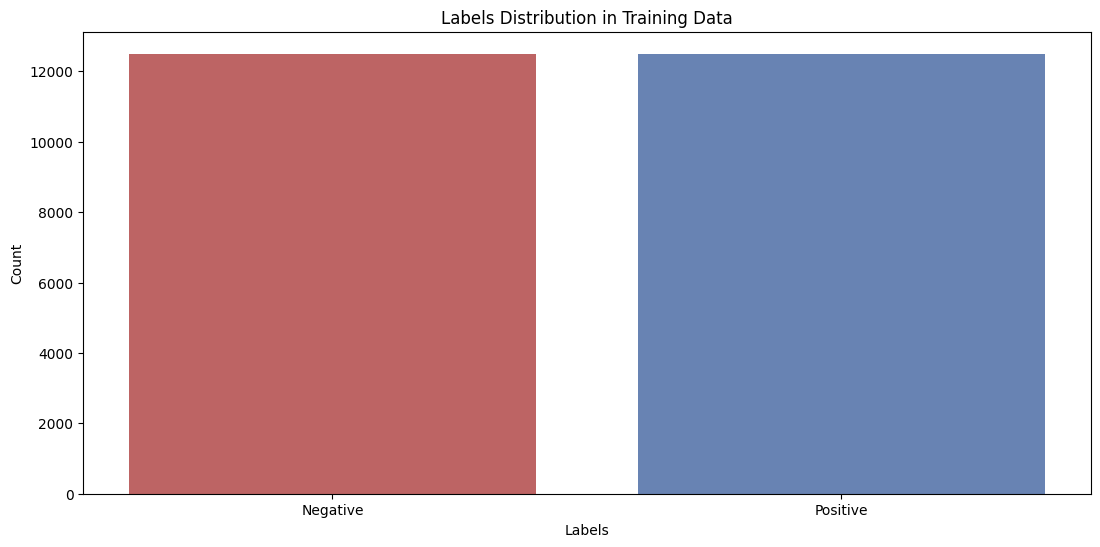

In [16]:
train_label_counts = plot_distribution(train)

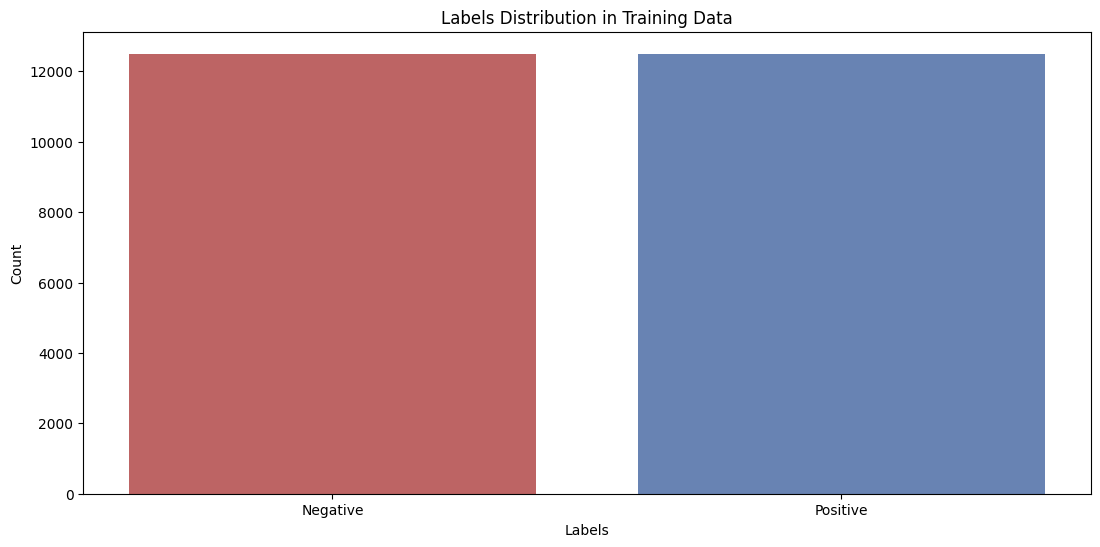

In [17]:
test_label_counts = plot_distribution(test)

In [18]:
print(f"Train Labels: {train_label_counts}\n Test Labels: {test_label_counts}\n ")

Train Labels: label
0    12500
1    12500
Name: count, dtype: int64
 Test Labels: label
0    12500
1    12500
Name: count, dtype: int64
 


Dataset Balance. Reviews are 50% positive, 50% negative.

In [19]:
train['text_length'] = train['text'].apply(len)
test['text_length'] = test['text'].apply(len)

In [20]:
train['text_length'].describe()

,text_length
count,25000.00000
mean,1325.06964
std,1003.13367
min,52.00000
25%,702.00000
50%,979.00000
75%,1614.00000
max,13704.00000


In [21]:
test['text_length'].describe()

,text_length
count,25000.00000
mean,1293.79240
std,975.90776
min,32.00000
25%,696.00000
50%,962.00000
75%,1572.00000
max,12988.00000


In [22]:
train_med = train['text_length'].median()
test_med = test['text_length'].median()

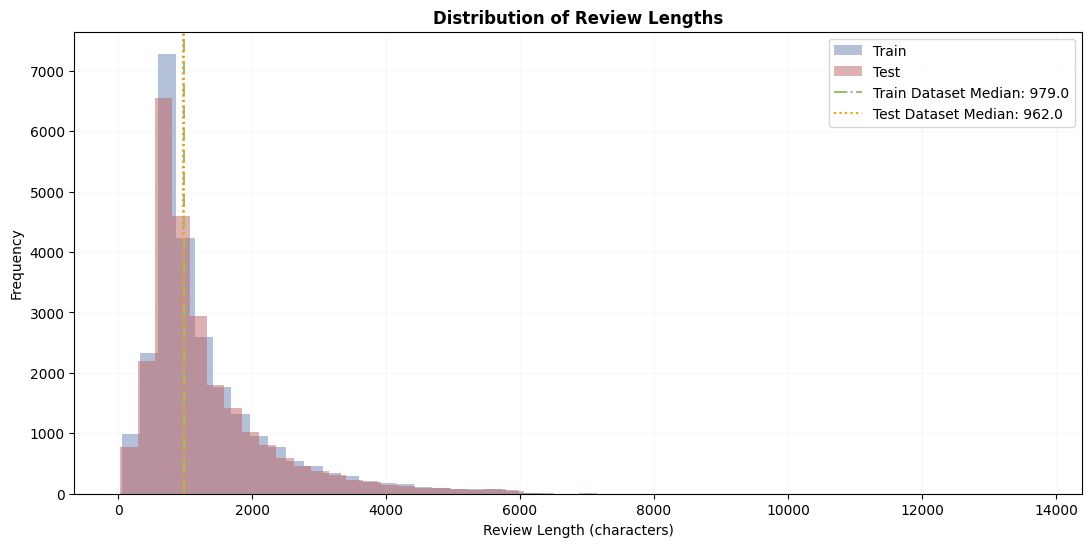

In [23]:
plt.hist(train['text_length'], bins = 50, alpha = 0.5, label = 'Train', color = BLUE)
plt.hist(test['text_length'], bins = 50, alpha = 0.5, label = 'Test', color = RED)

plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

plt.title('Distribution of Review Lengths', fontsize=12, fontweight='bold')

plt.axvline(train_med, color = GREEN, alpha = 1, linestyle = '-.',
            label = f"Train Dataset Median: {train_med}")
plt.axvline(test_med, color = ORANGE, alpha = 1, linestyle = ':',
            label = f"Test Dataset Median: {test_med}")

plt.grid(alpha = 0.075)

plt.legend()

plt.savefig(f'{IMG_DIR}/text_length_distribution.png')

plt.show()

## Tokenization

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
rand_sample = train.loc[train['text_length'] < 150, 'text'].iloc[1]

In [27]:
print(f"Original Text: \"{rand_sample}\"")

Original Text: "You'd better choose Paul Verhoeven's even if you have watched it."


In [28]:
tokens = tokenizer.tokenize(rand_sample)

In [29]:
print(f"{tokens[:5]}...")
print(f"Tokens Length: {len(tokens)}")

['you', "'", 'd', 'better', 'choose']...
Tokens Length: 19


In [30]:
token_ids = tokenizer.encode(rand_sample, add_special_tokens = True)

In [31]:
print(f"{token_ids[:5]}...")
print(f"Encoded Tokens Length: {len(token_ids)}")

[101, 2017, 1005, 1040, 2488]...
Encoded Tokens Length: 21


In [32]:
decoded_tokens = tokenizer.decode(token_ids)
print(f"{decoded_tokens}...")

[CLS] you'd better choose paul verhoeven's even if you have watched it. [SEP]...


Creating Dataset Class

In [33]:
class ReviewDataset(Dataset):
    """
    Uses the BERT Tokenizer to Tokenize Text
    and prepare data in BERT format
    """

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, id):
        text = str(self.texts[id])
        label = self.labels[id]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_length,
            return_token_type_ids = False,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype = torch.long)
        }

In [34]:
train_ds = ReviewDataset(
    texts = train['text'].tolist(),
    labels = train['label'].tolist(),
    tokenizer = tokenizer,
    max_length = 512
)

test_ds = ReviewDataset(
    texts = test['text'].tolist(),
    labels = test['label'].tolist(),
    tokenizer = tokenizer,
    max_length = 512
)

In [35]:
print(len(train_ds))
print(len(test_ds))

25000
25000


In [36]:
train_loader = DataLoader(
    train_ds,
    batch_size = 8,
    shuffle = True,
    num_workers = 2
)

test_loader = DataLoader(
    test_ds,
    batch_size = 8,
    shuffle = False,
    num_workers = 2
)

In [37]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
optimizer = AdamW(
    model.parameters(),
    lr = 0.001,
    eps = 1e-8,  # Epsilon for numerical stability
    weight_decay = 0.01
)

In [39]:
sum_steps = len(train_loader) * 3
warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = sum_steps
)

In [40]:
# For Tracking Traning Progress
training_stats = []

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [43]:
print(f"Initiating traning using: {device}...")

Initiating traning using: cuda...


In [45]:
for epoch in range(3):

    model.train()

    # For tracking training progress
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    print(f"Epoch {epoch + 1}/{3} - Training...")

    for batch_num, batch in enumerate(train_loader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        scheduler.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        train_predictions.extend(preds)
        train_true_labels.extend(labels_cpu)

        if (batch_num + 1) % 10 == 0:
            print(f"Batch {batch_num + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    print("Evaluating on test set...")

    # Model Evaluation
    model.eval()

    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch_num, batch in enumerate(test_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            val_predictions.extend(preds)
            val_true_labels.extend(labels_cpu)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch {batch_num + 1}/{len(test_loader)}")

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_true_labels,
        val_predictions,
        average = 'binary'
    )

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    # Storing stats for later plotting and persisting (saving) to storage
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

Epoch 1/3 - Training...
Batch 10/3125 - Loss: 0.6529
Batch 20/3125 - Loss: 0.6681
Batch 30/3125 - Loss: 0.6527
Batch 40/3125 - Loss: 0.6199
Batch 50/3125 - Loss: 0.6419
Batch 60/3125 - Loss: 0.2820
Batch 70/3125 - Loss: 0.5302
Batch 80/3125 - Loss: 1.2388
Batch 90/3125 - Loss: 0.5972
Batch 100/3125 - Loss: 0.5422
Batch 110/3125 - Loss: 0.6136
Batch 120/3125 - Loss: 0.5748
Batch 130/3125 - Loss: 0.9103
Batch 140/3125 - Loss: 0.5601
Batch 150/3125 - Loss: 0.6740
Batch 160/3125 - Loss: 0.8769
Batch 170/3125 - Loss: 0.8854
Batch 180/3125 - Loss: 0.7797
Batch 190/3125 - Loss: 0.7079
Batch 200/3125 - Loss: 0.6724
Batch 210/3125 - Loss: 0.7026
Batch 220/3125 - Loss: 0.6971
Batch 230/3125 - Loss: 0.6983
Batch 240/3125 - Loss: 0.7141
Batch 250/3125 - Loss: 0.6236
Batch 260/3125 - Loss: 0.6232
Batch 270/3125 - Loss: 0.6991
Batch 280/3125 - Loss: 0.6444
Batch 290/3125 - Loss: 0.7682
Batch 300/3125 - Loss: 1.0645
Batch 310/3125 - Loss: 0.6855
Batch 320/3125 - Loss: 0.7821
Batch 330/3125 - Loss: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 10/3125 - Loss: 0.6980
Batch 20/3125 - Loss: 0.6559
Batch 30/3125 - Loss: 0.7690
Batch 40/3125 - Loss: 0.7701
Batch 50/3125 - Loss: 0.7544
Batch 60/3125 - Loss: 0.6288
Batch 70/3125 - Loss: 0.6677
Batch 80/3125 - Loss: 0.6283
Batch 90/3125 - Loss: 0.9727
Batch 100/3125 - Loss: 0.7550
Batch 110/3125 - Loss: 0.6657
Batch 120/3125 - Loss: 0.8801
Batch 130/3125 - Loss: 0.6971
Batch 140/3125 - Loss: 0.6765
Batch 150/3125 - Loss: 0.7813
Batch 160/3125 - Loss: 0.6664
Batch 170/3125 - Loss: 0.8062
Batch 180/3125 - Loss: 0.6981
Batch 190/3125 - Loss: 0.6584
Batch 200/3125 - Loss: 0.7068
Batch 210/3125 - Loss: 0.7078
Batch 220/3125 - Loss: 0.8837
Batch 230/3125 - Loss: 0.6803
Batch 240/3125 - Loss: 0.6962
Batch 250/3125 - Loss: 0.7420
Batch 260/3125 - Loss: 0.8006
Batch 270/3125 - Loss: 0.7462
Batch 280/3125 - Loss: 0.6744
Batch 290/3125 - Loss: 0.5927
Batch 300/3125 - Loss: 0.6729
Batch 310/3125 - Loss: 0.7062
Batch 320/3125 - Loss: 0.8472
Batch 330/3125 - Loss: 0.7372
Batch 340/3125 - Lo

In [47]:
y_train = train['label'].tolist()
X_train = train['text'].tolist()
y_test = test['label'].tolist()
X_test = test['text'].tolist()

In [48]:
tfidf = TfidfVectorizer(
    max_features = 5000,
    ngram_range = (1, 2),
    min_df = 5
)

In [49]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [50]:
feature_names = tfidf.get_feature_names_out()

In [51]:
lr_model = LogisticRegression(
    max_iter = 1000,
    random_state = GLOBAL_SEED,
    n_jobs = -1
)

In [52]:
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1000)

In [53]:
lr_predictions = lr_model.predict(X_test_tfidf)

In [54]:
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_test,
    lr_predictions,
    average='binary'
)

In [55]:
print("Logistics Regression Results")
print(f"Precision: {lr_precision:.4f}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

Logistics Regression Results
Precision: 0.8840
Accuracy: 0.8884
Recall: 0.8941
F1-Score: 0.8890


In [56]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [57]:
nb_predictions = nb_model.predict(X_test_tfidf)

In [58]:
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test,
    nb_predictions,
    average = 'binary'
)

In [59]:
print("Naive Bayes Results")
print(f"Precision: {nb_precision:.4f}")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-Score: {nb_f1:.4f}")

Naive Bayes Results
Precision: 0.8527
Accuracy: 0.8554
Recall: 0.8592
F1-Score: 0.8559


In [ ]:
stats_df = pd.DataFrame(training_stats)

stats_output_path = os.path.join(IMG_DIR, 'bert_training_stats.csv')
stats_df.to_csv(stats_output_path, index = False)

print(f"Training statistics saved to {stats_output_path}")

In [60]:
model.eval()
bert_predictions = []
bert_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="BERT Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        bert_predictions.extend(preds)
        bert_true_labels.extend(labels.cpu().numpy())


bert_accuracy = accuracy_score(bert_true_labels, bert_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_true_labels,
    bert_predictions,
    average = 'binary'
)

print(f"BERT Results:")
print(f"Accuracy:  {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall:    {bert_recall:.4f}")
print(f"F1-Score:  {bert_f1:.4f}")


Generating BERT predictions on test set...


BERT Inference:   0%|          | 0/3125 [00:00<?, ?it/s]


BERT Results:
  Accuracy:  0.5000
  Precision: 0.5000
  Recall:    1.0000
  F1-Score:  0.6667


In [70]:
model_output_dir = os.path.join(IMG_DIR, 'fine_tuned_bert_model')

os.makedirs(model_output_dir, exist_ok=True)

model.save_pretrained(model_output_dir)

print(f"Fine-tuned BERT model saved to: {model_output_dir}")

Fine-tuned BERT model saved to: images/fine_tuned_bert_model


In [61]:
def compare_models():

    comparison_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Naive Bayes', 'BERT (Fine-tuned)'],
        'Accuracy': [lr_accuracy, nb_accuracy, bert_accuracy],
        'Precision': [lr_precision, nb_precision, bert_precision],
        'Recall': [lr_recall, nb_recall, bert_recall],
        'F1-Score': [lr_f1, nb_f1, bert_f1]
    })

    print(comparison_df.to_string(index = False))

    comparison_df.to_csv(f'{IMG_DIR}/model_comparison.csv', index = False)
    print(f"Comparison saved to {IMG_DIR}/model_comparison.csv")

compare_models()

MODEL COMPARISON

              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8884   0.884037 0.89408  0.889030
        Naive Bayes    0.8554   0.852719 0.85920  0.855947
  BERT (Fine-tuned)    0.5000   0.500000 1.00000  0.666667

✓ Comparison saved to images/model_comparison.csv


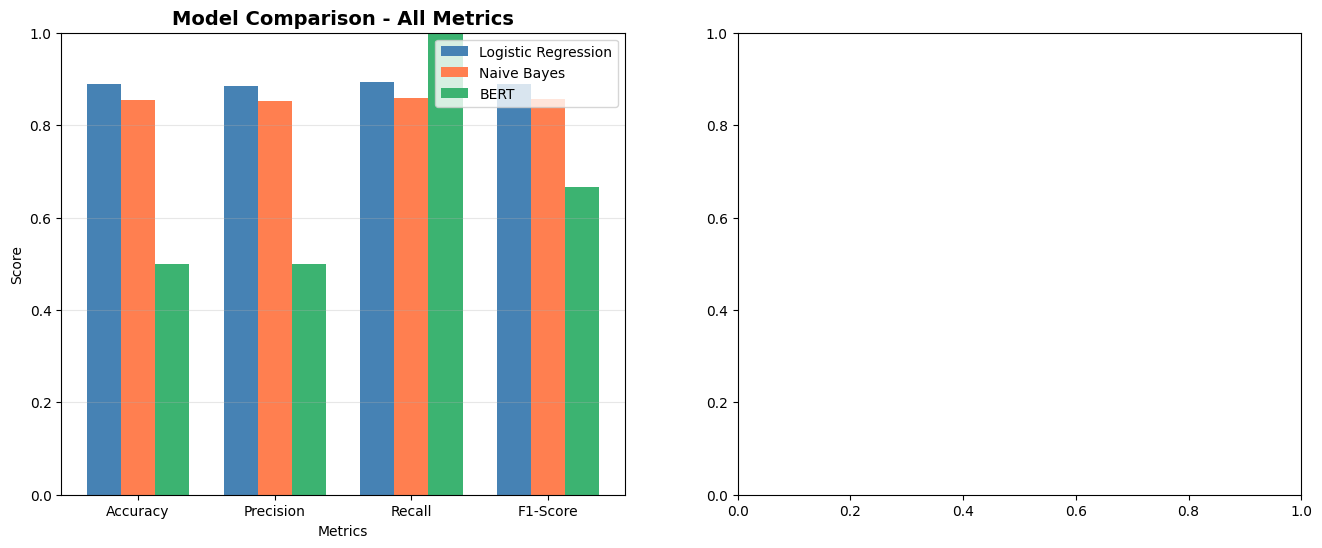

In [62]:
def plot_model_comparison_bar_chart():

    fig, ax = plt.figure(figsize = (16, 6))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    x = np.arange(len(metrics))

    width = 0.25

    bars1 = ax.bar(x - width, comparison_df.iloc[0, 1:], width,
                        label = 'Logistic Regression Model', color = BLUE)
    bars2 = ax.bar(x, comparison_df.iloc[1, 1:], width,
                        label = 'Naive Bayes Model', color = GREEN)
    bars3 = ax.bar(x + width, comparison_df.iloc[2, 1:], width,
                        label = 'BERT Model', color = ORANGE)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Including All Metrics', fontsize = 14, fontweight = 'bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 1.0])
    ax.grid(axis = 'y', alpha = 0.05)

plot_model_comparison_bar_chart()

CONFUSION MATRICES


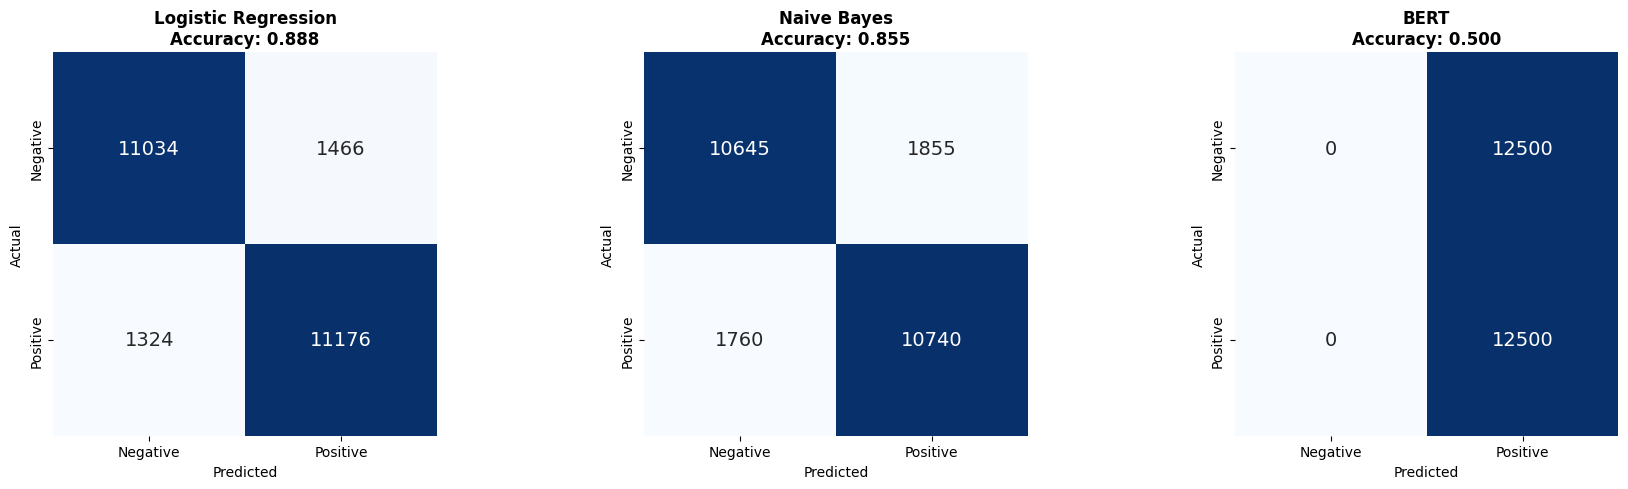

In [68]:
def plot_confusion_matrix():

    fig, ax = plt.subplots(1, 3, figsize = (18, 5))

    models_data = [
        ('Logistic Regression', lr_predictions),
        ('Naive Bayes', nb_predictions),
        ('BERT', bert_predictions)
    ]

    for id, (name, preds) in enumerate(models_data):
        cm = confusion_matrix(y_test if id < 2 else bert_true_labels, preds)

        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', ax = ax[id],
                    cbar = False, square = True, annot_kws = {'size': 12})
        ax[id].set_title(f'{name} Accuracy: {comparison_df.iloc[id]["Accuracy"]:.3f}',
                        fontsize = 10)
        ax[id].set_xlabel('Predicted Labels')
        ax[id].set_ylabel('Actual Labels')
        ax[id].set_xticklabels(['Negative', 'Positive'])
        ax[id].set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.savefig(f'{IMG_DIR}/confusion_matrices.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

plot_confusion_matrix()

In [ ]:
def get_classification_report():

    for name, predictions in [
        ('Logistic Regression', lr_predictions),
        ('Naive Bayes', nb_predictions),
        ('BERT', bert_predictions)]:

        print(name)

        true_labels = y_test if name != 'BERT' else bert_true_labels

        print(classification_report(true_labels, predictions,
                                    target_names = ['Negative', 'Positive']))

get_classification_report()

In [ ]:
# Calculating BERT model accuracy increase
def calculaye_bert_accuracy_increase(original_accuracy, new_accuracy = bert_accuracy):
    return ((new_accuracy - original_accuracy) / original_accuracy) * 100

lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

In [69]:
# Model,Accuracy,Precision,Recall,F1-Score
# Logistic Regression,0.8884,0.8840373358645784,0.89408,0.889030307851404
# Naive Bayes,0.8554,0.8527193330686781,0.8592,0.8559473998804543
# BERT (Fine-tuned),0.5,0.5,1.0,0.6666666666666666

## Modifying Traning Parameters (HYPER PARAMETER TUNING)

In [ ]:
# Further Reducing learning Rate

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, # 0.001,
    eps = 1e-8,
    weight_decay = 0.01
)

In [ ]:
sum_steps = len(train_loader) * 3
warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = sum_steps
)

In [ ]:
for epoch in range(3):

    model.train()

    # For tracking training progress
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    print(f"Epoch {epoch + 1}/{3} - Training...")

    for batch_num, batch in enumerate(train_loader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        scheduler.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        train_predictions.extend(preds)
        train_true_labels.extend(labels_cpu)

        if (batch_num + 1) % 10 == 0:
            print(f"Batch {batch_num + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    print("Evaluating on test set...")

    # Model Evaluation
    model.eval()

    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch_num, batch in enumerate(test_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            val_predictions.extend(preds)
            val_true_labels.extend(labels_cpu)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch {batch_num + 1}/{len(test_loader)}")

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_true_labels,
        val_predictions,
        average = 'binary'
    )

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    # Storing stats for later plotting and persisting (saving) to storage
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

Get Post Traning Statistics and Plot Graphs

In [ ]:
compare_models()

lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

In [ ]:
plot_model_comparison_bar_chart()

In [ ]:
plot_confusion_matrix()

In [ ]:
get_classification_report()

In [ ]:
lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"Hypertuned BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")